In [ ]:
!pip install sentencepiece

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import torch
from transformers import BertTokenizer, BertForSequenceClassification
from transformers import AdamW
from torch.utils.data import Dataset, DataLoader

import pandas as pd


def read_csv(filename, column_name):
    df = pd.read_csv(filename)
    data = df[column_name]
    return data


class SQLDataset(Dataset):
    def __init__(self, queries, labels):
        self.queries = queries
        self.labels = labels
        self.tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

    def __len__(self):
        return len(self.queries)

    def __getitem__(self, idx):
        query = self.queries[idx]
        label = self.labels[idx]
        encoding = self.tokenizer.encode_plus(
            query,
            add_special_tokens=True,
            padding='max_length',
            max_length=512,
            truncation=True,
            return_tensors='pt'
        )

        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(label, dtype=torch.long)
        }


dataset = SQLDataset(queries, labels)


model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=3)


optimizer = AdamW(model.parameters(), lr=1e-5)


batch_size = 2


dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)


epochs = 5
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


model.to(device)
model.train()

for epoch in range(epochs):
    print(f'Epoch {epoch + 1}/{epochs}')
    print('-' * 10)

    total_loss = 0

    for batch in dataloader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        optimizer.zero_grad()

        outputs = model(input_ids=input_ids,
                        attention_mask=attention_mask,
                        labels=labels)

        loss = outputs.loss
        total_loss += loss.item()

        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        optimizer.step()

    average_loss = total_loss / len(dataloader)
    print(f'Average Loss: {average_loss}')


model.save_pretrained('bert-sql-model')


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

Epoch 1/5
----------
Average Loss: 1.0632626414299011
Epoch 2/5
----------
Average Loss: 1.3177355527877808
Epoch 3/5
----------
Average Loss: 0.9382308721542358
Epoch 4/5
----------
Average Loss: 0.9894682466983795
Epoch 5/5
----------
Average Loss: 1.1048793196678162


In [ ]:
import torch
from transformers import BertTokenizer, BertForSequenceClassification
from transformers import AdamW
from torch.utils.data import Dataset, DataLoader
import pandas as pd

def read_csv(filename, column_name):
    df = pd.read_csv(filename)
    data = df[column_name]
    return data


class TextQueryDataset(Dataset):
    def __init__(self, texts, queries, labels):
        self.texts = texts
        self.queries = queries
        self.labels = labels
        self.tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        query = self.queries[idx]
        label = self.labels[idx]
        encoding = self.tokenizer.encode_plus(
            text,
            query,
            add_special_tokens=True,
            padding='max_length',
            max_length=128,
            truncation=True,
            return_tensors='pt'
        )
        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(label, dtype=torch.long)
        }


texts = read_csv("dataset_text.csv", 'text')
queries = read_csv("dataset_cypher_skimmed.csv", 'cypher')
labels = [i for i in range(len(texts))]

t = texts[:32]
q = queries[:32]
l = labels[:32]
dataset_train = TextQueryDataset(t, q, l)


model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=len(dataset_train))


optimizer = AdamW(model.parameters(), lr=1e-5)


batch_size = 2
dataloader_train = DataLoader(dataset_train, batch_size=batch_size, shuffle=True)
# dataloader_test = DataLoader(dataset_test, batch_size=batch_size, shuffle=True)

def train():
  avg_loss = []

  epochs = 5
  device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
  model.to(device)
  model.train()

  for epoch in range(epochs):
      print(f'Epoch {epoch + 1}/{epochs}')
      print('-' * 10)

      total_loss = 0

      for batch in dataloader_train:
          input_ids = batch['input_ids'].to(device)
          attention_mask = batch['attention_mask'].to(device)
          labels = batch['labels'].to(device)

          optimizer.zero_grad()

          outputs = model(input_ids=input_ids,
                          attention_mask=attention_mask,
                          labels=labels)

          loss = outputs.loss
          total_loss += loss.item()

          loss.backward()
          torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

          optimizer.step()

      average_loss = total_loss / len(dataloader_train)
      avg_loss.append(average_loss)
      print(f'Average Loss: {average_loss}')

  model.save_pretrained('bert-sql-model')

  return avg_loss

store_loss = train()

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

Epoch 1/5
----------
Average Loss: 3.548569083213806
Epoch 2/5
----------
Average Loss: 3.466788187623024
Epoch 3/5
----------
Average Loss: 3.39273239672184
Epoch 4/5
----------
Average Loss: 3.427923157811165
Epoch 5/5
----------
Average Loss: 3.299599841237068


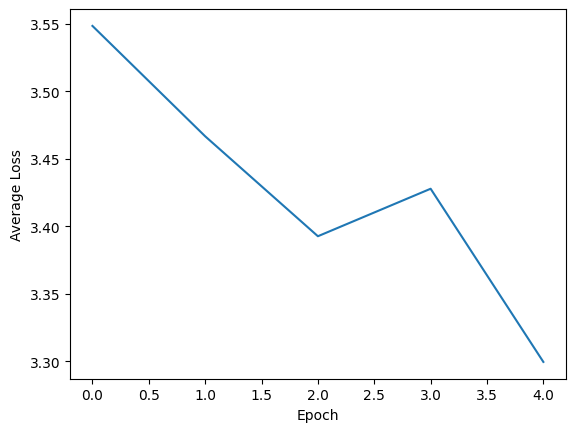

In [ ]:
import matplotlib.pyplot as plt

plt.xlabel("Epoch")
plt.ylabel("Average Loss")
plt.plot(store_loss, label = "Loss")
plt.legend()
plt.show()

In [ ]:
model = BertForSequenceClassification.from_pretrained('bert-sql-model')
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

text = "What are some recipes that can be served as both dinner and dessert?"
sql_query = "MATCH (r:Recipe) WHERE 'dinner' IN r.meal_types AND 'dessert' IN r.serving_suggestions RETURN r.name"


encoding = tokenizer.encode_plus(
    text,
    sql_query,
    add_special_tokens=True,
    padding='max_length',
    max_length=128,
    truncation=True,
    return_tensors='pt'
)


input_ids = encoding['input_ids'].flatten()
attention_mask = encoding['attention_mask'].flatten()


outputs = model(input_ids=input_ids.unsqueeze(0), attention_mask=attention_mask.unsqueeze(0))


predicted_label = torch.argmax(outputs.logits, dim=1).item()

print("Predicted Label:", predicted_label)

print(texts[predicted_label])

print(queries[predicted_label])

Predicted Label: 9
Could you suggest some Moroccan recipes that are both healthy and low in sodium?
MATCH (r:Recipe) WHERE r.cuisine = 'Moroccan' AND r.healthiness = 'healthy' AND r.sodiumLevel = 'low' RETURN r.name r.description r2.name


In [ ]:
import nltk


hypothesis = queries[predicted_label].split(" ")
print(hypothesis)

reference = sql_query.split(" ")
print(reference)

BLEUscore = nltk.translate.bleu_score.sentence_bleu([reference], hypothesis)
print(BLEUscore)

['MATCH', '(r:Recipe)', 'WHERE', 'r.cuisine', '=', "'Moroccan'", 'AND', 'r.healthiness', '=', "'healthy'", 'AND', 'r.sodiumLevel', '=', "'low'", 'RETURN', 'r.name', 'r.description', 'r2.name']
['MATCH', '(r:Recipe)', 'WHERE', "'dinner'", 'IN', 'r.meal_types', 'AND', "'dessert'", 'IN', 'r.serving_suggestions', 'RETURN', 'r.name']
3.0074186032008e-78


/usr/local/lib/python3.10/dist-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)


In [ ]:
import torch
from transformers import T5Tokenizer, T5ForConditionalGeneration
from torch.utils.data import Dataset, DataLoader


class TextSqlQueryDataset(Dataset):
    def __init__(self, texts, queries, tokenizer):
        self.texts = texts
        self.queries = queries
        self.tokenizer = tokenizer

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        query = self.queries[idx]
        encoding = self.tokenizer.encode_plus(
            text,
            query,
            padding='max_length',
            max_length=128,
            truncation=True,
            return_tensors='pt'
        )
        input_ids = encoding['input_ids'].flatten()
        attention_mask = encoding['attention_mask'].flatten()
        return {
            'input_ids': input_ids,
            'attention_mask': attention_mask,
            'target_ids': input_ids,
            'target_attention_mask': attention_mask,
        }


texts = ['The weather is nice today.',
         'I need a recipe for spaghetti.',
         'What are the top tourist attractions in Paris?']
queries = ['SELECT * FROM weather WHERE date = TODAY;',
           'SELECT * FROM recipes WHERE dish = "spaghetti";',
           'SELECT * FROM attractions WHERE city = "Paris";']

tokenizer = T5Tokenizer.from_pretrained('t5-base')
dataset = TextSqlQueryDataset(texts, queries, tokenizer)


model = T5ForConditionalGeneration.from_pretrained('t5-base')


optimizer = torch.optim.AdamW(model.parameters(), lr=1e-5)


batch_size = 2
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)


epochs = 5
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


model.to(device)
model.train()

for epoch in range(epochs):
    print(f'Epoch {epoch + 1}/{epochs}')
    print('-' * 10)

    total_loss = 0

    for batch in dataloader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        target_ids = batch['target_ids'].to(device)
        target_attention_mask = batch['target_attention_mask'].to(device)

        optimizer.zero_grad()

        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask,
            decoder_input_ids=target_ids,
            decoder_attention_mask=target_attention_mask,
            labels=target_ids
        )

        loss = outputs.loss
        total_loss += loss.item()

        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        optimizer.step()

    average_loss = total_loss / len(dataloader)
    print(f'Average Loss: {average_loss}')


model.save_pretrained('t5-text-sql-query-generation-model')


TypeError: ignored

In [ ]:
!pip install tokenizers==0.10.3
!pip install transformers==4.5.0
tokenizer = T5Tokenizer.from_pretrained('t5-base')


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Using cached tokenizers-0.10.3.tar.gz (212 kB)
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  error: subprocess-exited-with-error
  
  × Building wheel for tokenizers (pyproject.toml) did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  ERROR: Failed building wheel for tokenizers
Failed to build tokenizers
ERROR: Could not build wheels for tokenizers, which is required to install pyproject.toml-based projects
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Using cached transformers-4.5.0-py3-none-any.whl (2.1 MB)
  Using cached sacremoses-0.0.53-py3-none-any.whl
  Using cached tokenizers-0.10.3.tar.gz (212 kB)
  Installing build dependenc

TypeError: ignored

In [ ]:
import torch
from transformers import BertTokenizer, BertForSequenceClassification


model = BertForSequenceClassification.from_pretrained('bert-sql-model')
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')


text = "Can you suggest a good Italian restaurant in New York?"
sql_query = "SELECT name, address FROM restaurants WHERE cuisine = 'Italian' AND city = 'New York'"


encoding = tokenizer.encode_plus(
    text,
    sql_query,
    add_special_tokens=True,
    padding='max_length',
    max_length=128,
    truncation=True,
    return_tensors='pt'
)

input_ids = encoding['input_ids'].flatten()
attention_mask = encoding['attention_mask'].flatten()


outputs = model(input_ids=input_ids.unsqueeze(0), attention_mask=attention_mask.unsqueeze(0))


predicted_label = torch.argmax(outputs.logits, dim=1).item()

print("Predicted Label:", predicted_label)


Predicted Label: 12


In [ ]:
import torch
from transformers import BertTokenizer, BertForSequenceClassification
from transformers import AdamW
from torch.utils.data import Dataset, DataLoader


class TextQueryDataset(Dataset):
    def __init__(self, texts, queries, labels):
        self.texts = texts
        self.queries = queries
        self.labels = labels
        self.tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        query = self.queries[idx]
        label = self.labels[idx]
        encoding = self.tokenizer.encode_plus(
            text,
            query,
            add_special_tokens=True,
            padding='max_length',
            max_length=128,
            truncation=True,
            return_tensors='pt'
        )
        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(label, dtype=torch.long)
        }


texts = ['The weather is nice today.',
         'I need a recipe for spaghetti.',
         'What are the top tourist attractions in Paris?']
queries = ['What is the weather like?',
           'How do I make spaghetti?',
           'List popular tourist spots in Paris.']
labels = [0, 1, 2]

dataset = TextQueryDataset(texts, queries, labels)


model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=3)


optimizer = AdamW(model.parameters(), lr=1e-5)


batch_size = 2
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)


epochs = 5
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


model.to(device)
model.train()

for epoch in range(epochs):
    print(f'Epoch {epoch + 1}/{epochs}')
    print('-' * 10)

    total_loss = 0

    for batch in dataloader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        optimizer.zero_grad()

        outputs = model(input_ids=input_ids,
                        attention_mask=attention_mask,
                        labels=labels)

        loss = outputs.loss
        total_loss += loss.item()

        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        optimizer.step()

    average_loss = total_loss / len(dataloader)
    print(f'Average Loss: {average_loss}')


model.save_pretrained('bert-text-query-model')


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

Epoch 1/5
----------
Average Loss: 0.9184134304523468
Epoch 2/5
----------
Average Loss: 1.0645493865013123
Epoch 3/5
----------
Average Loss: 0.9430181384086609
Epoch 4/5
----------
Average Loss: 0.7694268822669983
Epoch 5/5
----------
Average Loss: 0.767183244228363


Approach - 2

In [ ]:
from transformers import AutoModelWithLMHead, AutoTokenizer

model_name = "bert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelWithLMHead.from_pretrained(model_name)

/usr/local/lib/python3.10/dist-packages/transformers/models/auto/modeling_auto.py:1322: FutureWarning: The class `AutoModelWithLMHead` is deprecated and will be removed in a future version. Please use `AutoModelForCausalLM` for causal language models, `AutoModelForMaskedLM` for masked language models and `AutoModelForSeq2SeqLM` for encoder-decoder models.
  warnings.warn(
Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification 

In [ ]:
input_sequences = [] 
output_sequences = []


for i in range(len(texts)):
  input_sequence = tokenizer.encode(texts[i], add_special_tokens=False)
  output_sequence = tokenizer.encode(queries[i], add_special_tokens=False)

  input_sequence.append(tokenizer.sep_token_id)
  input_sequence.extend(output_sequence)

  input_sequences.append(input_sequence)
  output_sequences.append(output_sequence)


In [ ]:
from transformers import Trainer, TrainingArguments, DataCollatorForLanguageModeling


data_collator = DataCollatorForLanguageModeling(tokenizer=tokenizer, mlm=False)


training_args = TrainingArguments(
    output_dir="./results",
    overwrite_output_dir=True,
    num_train_epochs=3,
    per_device_train_batch_size=16,
    save_total_limit=2,
    learning_rate=2e-5,
    prediction_loss_only=True,
)


trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=input_sequences,
    data_collator=data_collator,
)


trainer.train()

ValueError: ignored

In [ ]:
prompt = "What are some healthy Moroccan recipes that are low in sodium?"

input_ids = tokenizer.encode(prompt, return_tensors="pt")
output_ids = model.generate(input_ids, max_length=100, do_sample=True)

output_text = tokenizer.decode(output_ids[0], skip_special_tokens=True)


print(output_text)

TypeError: ignored

In [ ]:
entities = {"person": ["John Doe", "Jane Smith"], "city": ["New York"]}


query = "MATCH (p:person)-[:LIVES_IN]->(c:city) WHERE "

for entity_type, entity_values in entities.items():
    if entity_type == "person":
        query += "p.name IN " + str(entity_values) + " AND "
    elif entity_type == "city":
        query += "c.name IN " + str(entity_values) + " AND "


query = query[:-4] + "RETURN p, c"


print(query)

MATCH (p:person)-[:LIVES_IN]->(c:city) WHERE p.name IN ['John Doe', 'Jane Smith'] AND c.name IN ['New York'] RETURN p, c
